## Detecting Phishing Websites Using URL-Based, HTML-Based, and Domain-Based Features

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np

In [2]:
df = pd.read_csv('dataset_phishing.csv')

In [3]:
df["status"].head()

0    legitimate
1      phishing
2      phishing
3    legitimate
4    legitimate
Name: status, dtype: object

In [4]:
df['status'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11430 entries, 0 to 11429
Series name: status
Non-Null Count  Dtype 
--------------  ----- 
11430 non-null  object
dtypes: object(1)
memory usage: 89.4+ KB


In [5]:

for i, col in enumerate(df.columns): print(f'{i+1}. {col}')

1. url
2. length_url
3. length_hostname
4. ip
5. nb_dots
6. nb_hyphens
7. nb_at
8. nb_qm
9. nb_and
10. nb_or
11. nb_eq
12. nb_underscore
13. nb_tilde
14. nb_percent
15. nb_slash
16. nb_star
17. nb_colon
18. nb_comma
19. nb_semicolumn
20. nb_dollar
21. nb_space
22. nb_www
23. nb_com
24. nb_dslash
25. http_in_path
26. https_token
27. ratio_digits_url
28. ratio_digits_host
29. punycode
30. port
31. tld_in_path
32. tld_in_subdomain
33. abnormal_subdomain
34. nb_subdomains
35. prefix_suffix
36. random_domain
37. shortening_service
38. path_extension
39. nb_redirection
40. nb_external_redirection
41. length_words_raw
42. char_repeat
43. shortest_words_raw
44. shortest_word_host
45. shortest_word_path
46. longest_words_raw
47. longest_word_host
48. longest_word_path
49. avg_words_raw
50. avg_word_host
51. avg_word_path
52. phish_hints
53. domain_in_brand
54. brand_in_subdomain
55. brand_in_path
56. suspecious_tld
57. statistical_report
58. nb_hyperlinks
59. ratio_intHyperlinks
60. ratio_extHy

In [6]:
df["status"].value_counts(normalize=True)  

status
legitimate    0.5
phishing      0.5
Name: proportion, dtype: float64

In [7]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
length_url,11430.0,61.126684,5.529732e+01,12.0,33.00,47.0,71.00,1641.0
length_hostname,11430.0,21.090289,1.077717e+01,4.0,15.00,19.0,24.00,214.0
ip,11430.0,0.150569,3.576436e-01,0.0,0.00,0.0,0.00,1.0
nb_dots,11430.0,2.480752,1.369686e+00,1.0,2.00,2.0,3.00,24.0
nb_hyphens,11430.0,0.997550,2.087087e+00,0.0,0.00,0.0,1.00,43.0
...,...,...,...,...,...,...,...,...
domain_age,11430.0,4062.543745,3.107785e+03,-12.0,972.25,3993.0,7026.75,12874.0
web_traffic,11430.0,856756.643307,1.995606e+06,0.0,0.00,1651.0,373845.50,10767986.0
dns_record,11430.0,0.020122,1.404254e-01,0.0,0.00,0.0,0.00,1.0
google_index,11430.0,0.533946,4.988682e-01,0.0,0.00,1.0,1.00,1.0


count    11430.000000
mean         0.053137
std          0.089363
min          0.000000
25%          0.000000
50%          0.000000
75%          0.079365
max          0.723881
Name: ratio_digits_url, dtype: float64

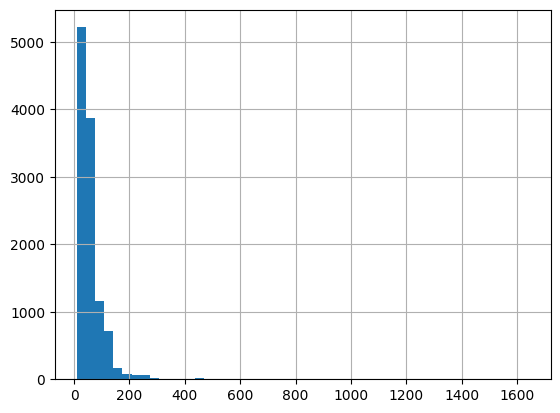

In [8]:
df["length_url"].hist(bins=50)
df["nb_dots"].value_counts()
df["ratio_digits_url"].describe()


Analysis of ratio_digits_url

The distribution of ratio_digits_url shows a pronounced right skew, with most URLs containing very few numeric characters relative to their overall length. The median sits at zero, which means at least half of all URLs include no digits at all. However, the long tail stretching toward the maximum value of approximately 0.72 reveals that a subset of URLs contains disproportionately high numeric density. This behaviour is characteristic of phishing infrastructure, where attackers frequently embed long numeric sequences to mimic session identifiers, obfuscate malicious patterns, or generate large batches of automated URLs.

Example implication:
A phishing URL such as
http://secure-login-verify-410873298.com/update/928374/confirm
exhibits a high digit ratio because both the hostname and path rely heavily on numeric padding to appear complex or legitimate.

Why this matters:
The skew indicates that while most legitimate domains remain alphanumeric with minimal digit usage, phishing URLs often inflate their numeric footprint. This separation makes ratio_digits_url a valuable discriminator for machine learning models, especially when combined with complementary lexical features like nb_dots, nb_hyphens, and length_url.

The comparison between legitimate and phishing domains reveals clear behavioural separation across age, registration length, and indexing patterns. Legitimate domains tend to be substantially older, with an average lifetime of more than five thousand days compared to just over three thousand for phishing sites, reflecting the long operating history typically associated with trusted organizations.

In [9]:
for col in df.columns:
    unique_value_list = df[col].unique()
    if len(unique_value_list) > 10:
        print(f'{col} has {df[col].nunique()} unique values')
    else:
        print(f'{col} contains:\t\t\t{unique_value_list}')

url has 11429 unique values
length_url has 324 unique values
length_hostname has 83 unique values
ip contains:			[0 1]
nb_dots has 19 unique values
nb_hyphens has 27 unique values
nb_at contains:			[0 1 2 3 4]
nb_qm contains:			[0 1 2 3]
nb_and has 15 unique values
nb_or contains:			[0]
nb_eq has 16 unique values
nb_underscore has 17 unique values
nb_tilde contains:			[0 1]
nb_percent has 25 unique values
nb_slash has 22 unique values
nb_star contains:			[0 1]
nb_colon contains:			[1 3 5 2 4 7]
nb_comma contains:			[0 1 2 4 3]
nb_semicolumn has 15 unique values
nb_dollar contains:			[0 1 2 3 6]
nb_space contains:			[ 0  1  3  2  5  4  6  7 18]
nb_www contains:			[1 0 2]
nb_com contains:			[0 1 2 3 6 5 4]
nb_dslash contains:			[0 1]
http_in_path contains:			[0 1 4 3 2]
https_token contains:			[1 0]
ratio_digits_url has 1414 unique values
ratio_digits_host has 241 unique values
punycode contains:			[0 1]
port contains:			[0 1]
tld_in_path contains:			[0 1]
tld_in_subdomain contains:			[0

<Axes: xlabel='status', ylabel='domain_age'>

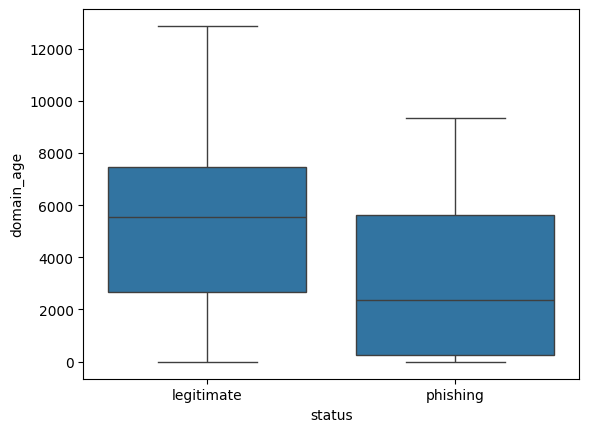

In [10]:
sns.boxplot(data=df, x='status', y='domain_age')


In [11]:
df['html_danger_score'] = (
    df['iframe'] +
    df['popup_window'] +
    df['submit_email'] +
    df['external_favicon'] +
    (1 - df['safe_anchor'])
)


In [12]:
df['statistical_risk'] = df['statistical_report'] + df['random_domain']


## Target Encoding

In [13]:
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})


In [14]:
df['status'].value_counts()


status
0    5715
1    5715
Name: count, dtype: int64

In [15]:
import pandas as pd

# Remove target
X = df.drop(columns=['status'])
y = df['status']

In [16]:
# Identify numerical columns (continuous or many unique values)
numerical_cols = [col for col in X.columns if X[col].dtype != 'object' and X[col].nunique() > 20]



In phishing-URL datasets, most variables fall into three natural groups:

1. Numerical features
2. Categorical features
3. Binary features

In [17]:
# Identify binary columns (0/1 only)
binary_cols = [col for col in X.columns 
               if X[col].nunique() == 2 and set(X[col].unique()).issubset({0,1})]

# Identify categorical columns: small number of discrete categories but not binary
categorical_cols = [col for col in X.columns 
                    if col not in numerical_cols and col not in binary_cols]

numerical_cols, binary_cols, categorical_cols[:10]  # show a sample

(['length_url',
  'length_hostname',
  'nb_hyphens',
  'nb_percent',
  'nb_slash',
  'ratio_digits_url',
  'ratio_digits_host',
  'length_words_raw',
  'char_repeat',
  'shortest_words_raw',
  'shortest_word_host',
  'shortest_word_path',
  'longest_words_raw',
  'longest_word_host',
  'longest_word_path',
  'avg_words_raw',
  'avg_word_host',
  'avg_word_path',
  'nb_hyperlinks',
  'ratio_intHyperlinks',
  'ratio_extHyperlinks',
  'nb_extCSS',
  'ratio_extRedirection',
  'ratio_extErrors',
  'links_in_tags',
  'ratio_intMedia',
  'ratio_extMedia',
  'safe_anchor',
  'domain_registration_length',
  'domain_age',
  'web_traffic',
  'html_danger_score'],
 ['ip',
  'nb_tilde',
  'nb_star',
  'nb_dslash',
  'https_token',
  'punycode',
  'port',
  'tld_in_path',
  'tld_in_subdomain',
  'abnormal_subdomain',
  'prefix_suffix',
  'random_domain',
  'shortening_service',
  'path_extension',
  'nb_external_redirection',
  'domain_in_brand',
  'brand_in_subdomain',
  'brand_in_path',
  'suspeci

The goal is to construct a preprocessing workflow that standardizes and encodes appropriately while preserving the semantic structure of each feature type
Why this pipeline works

A well-designed preprocessing chain ensures that:

Numerical features are normalized to stabilize gradient-based and distance-based models.

Binary features are passed through unchanged because scaling or encoding does not add information.

Categorical low-cardinality features can be safely one-hot encoded without inflating dimensionality.

This reduces noise, prevents feature dominance, and prepares your dataset for the most predictive models (tree ensembles, regularized linear models, and neural networks).

In [18]:


numerical_cols = ['length_url','length_hostname','nb_hyphens','nb_percent','nb_slash',
                  'ratio_digits_url','ratio_digits_host','length_words_raw','char_repeat',
                  'shortest_words_raw','shortest_word_host','shortest_word_path','longest_words_raw',
                  'longest_word_host','longest_word_path','avg_words_raw','avg_word_host','avg_word_path',
                  'nb_hyperlinks','ratio_intHyperlinks','ratio_extHyperlinks','nb_extCSS',
                  'ratio_extRedirection','ratio_extErrors','links_in_tags','ratio_intMedia',
                  'ratio_extMedia','safe_anchor','domain_registration_length','domain_age','web_traffic']

binary_cols = ['ip','nb_tilde','nb_star','nb_dslash','https_token','punycode','port','tld_in_path',
               'tld_in_subdomain','abnormal_subdomain','prefix_suffix','random_domain',
               'shortening_service','path_extension','nb_external_redirection','domain_in_brand',
               'brand_in_subdomain','brand_in_path','suspecious_tld','login_form','external_favicon',
               'iframe','popup_window','onmouseover','right_clic','empty_title','domain_in_title',
               'domain_with_copyright','whois_registered_domain','dns_record','google_index']

categorical_cols = ['nb_dots','nb_at','nb_qm','nb_and','nb_or','nb_eq','nb_underscore',
                    'nb_colon','nb_comma','nb_semicolumn']

# Transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

binary_transformer = 'passthrough'

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'))
])

# Combined preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('bin', binary_transformer, binary_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)


At this stage, the preprocessing pipeline becomes the backbone of the modeling lifecycle. Numerical values are standardized to ensure comparable scales, particularly important when features such as URL length or domain age vary by orders of magnitude. Binary indicators are preserved in their raw form to maintain interpretability and avoid unnecessary transformations. Categorical structure embedded in URL components is expressed through one-hot encoding, enabling algorithms to detect nonlinear interactions between symbolic patterns and phishing behavior. By consolidating these transformations in a unified ColumnTransformer, the pipeline guarantees reproducibility, guards against leakage, and integrates seamlessly with cross-validation and hyperparameter tuning workflows.

In [19]:
def create_domain_trust_score(df):
    """
    Creates a domain trust score based on domain characteristics
    Higher scores indicate more trustworthy domains
    """
    # Normalize domain age (older = more trustworthy)
    max_age = df['domain_age'].max()
    normalized_age = df['domain_age'] / max_age if max_age > 0 else 0
    
    # Normalize web traffic (more traffic = more trustworthy)
    max_traffic = df['web_traffic'].max()
    normalized_traffic = df['web_traffic'] / max_traffic if max_traffic > 0 else 0
    


In [20]:
def create_brand_spoofing_indicator(df):
    """
    Combines brand-related features to detect potential spoofing attempts
    """
    df['brand_spoofing_indicator'] = (
        df['domain_in_brand'] * 2 +  # Domain mimicking brand
        df['brand_in_subdomain'] * 1.5 +  # Brand name in subdomain
        df['brand_in_path'] +  # Brand name in path
        df['phish_hints']  # Phishing keywords
    )
    return df

## MODELLING

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [22]:
from sklearn.preprocessing import PowerTransformer

num_features = [
    'length_url', 'length_hostname', 'nb_hyphens', 'nb_percent',
    'nb_slash', 'ratio_digits_url', 'ratio_digits_host', 'length_words_raw',
    'char_repeat', 'shortest_words_raw', 'shortest_word_host',
    'shortest_word_path', 'longest_words_raw', 'longest_word_host',
    'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path',
    'nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 
    'nb_extCSS', 'ratio_extRedirection', 'ratio_extErrors', 'links_in_tags', 
    'ratio_intMedia', 'ratio_extMedia', 'safe_anchor', 'domain_registration_length',
    'domain_age', 'web_traffic'
]

pt = PowerTransformer()
df[num_features] = pt.fit_transform(df[num_features])


In [23]:
# Find columns with any NaN values
nan_columns = df.columns[df.isna().any()]
print("Columns with NaN values:\n", nan_columns)

# Optional: see how many NaNs per column
print("\nNumber of NaNs per column:\n", df[nan_columns].isna().sum())


Columns with NaN values:
 Index([], dtype='object')

Number of NaNs per column:
 Series([], dtype: float64)


In [24]:
df.columns = df.columns.str.strip()  # remove leading/trailing spaces
print(df['status'].head())


0    0
1    1
2    1
3    0
4    0
Name: status, dtype: int64


That means we can do unsupervised modeling like clustering or dimensionality reduction to explore patterns in the data.

In [25]:
# Get non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: ['url']


In [26]:
from sklearn.preprocessing import StandardScaler

# Drop the 'url' column (it's not a feature, just the raw URL text)
X = df.drop(columns=['url'])  # Drop both url and target variable

# Now scale the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


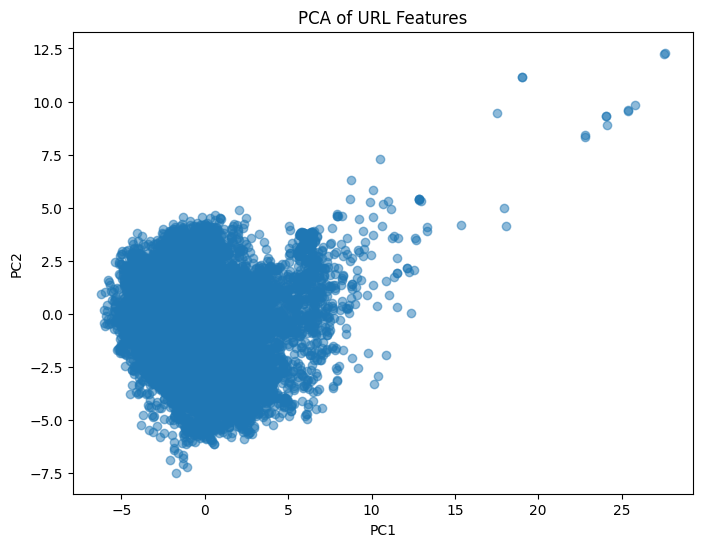

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of URL Features")
plt.show()


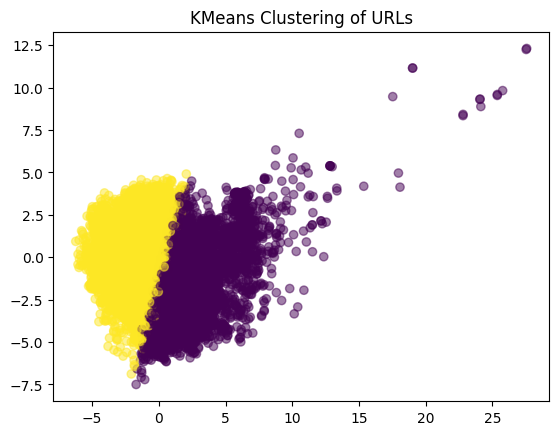

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.5)
plt.title("KMeans Clustering of URLs")
plt.show()


The colors represent different clusters identified by K-Means. They are unsupervised, so the algorithm doesn’t know which is phishing or legitimate yet.

Yellow points clustered from roughly -3 to 0 on the PC axis correspond to one cluster, while brown points around 5 correspond to the other cluster.

After comparing these clusters to your true labels (status), you can see which cluster mostly contains legitimate URLs and which mostly contains phishing URLs. This helps you understand how well K-Means separated the two types.

Overlapping areas indicate URLs where the algorithm finds them hard to separate, which is common because K-Means works on distance and t-SNE is only a 2D projection.

domain_trust_score

## Create X and y

In [29]:
df["status"].head(10)

0    0
1    1
2    1
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: status, dtype: int64

phishing → 1

legitimate → 0

In [30]:
X = df.drop(columns=["url"])   # drop target + non-useful text field
y = df["status"]


Train/Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\n📦 Data Split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")


📦 Data Split:
   Training set: 8572 samples
   Test set: 2858 samples


##Random forest

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [33]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
pred_rf = rf.predict(X_test)

In [35]:
accuracy = accuracy_score(y_test, pred_rf)
report = classification_report(y_test, pred_rf)
cm = confusion_matrix(y_test, pred_rf)

print("🔵 RANDOM FOREST RESULTS")
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", cm)

🔵 RANDOM FOREST RESULTS
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1429
           1       1.00      1.00      1.00      1429

    accuracy                           1.00      2858
   macro avg       1.00      1.00      1.00      2858
weighted avg       1.00      1.00      1.00      2858


Confusion Matrix:
 [[1429    0]
 [   0 1429]]


In [36]:
df.columns


Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

XGBoost Classification (for phishing detection)

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# X and y
X = df.drop(["status", "url"], axis=1)
y = df["status"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [38]:
df["status"].head()

0    0
1    1
2    1
3    0
4    0
Name: status, dtype: int64

In [39]:
df.dtypes[df.dtypes == "object"]


url    object
dtype: object

In [40]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [41]:
pred_xgb = xgb.predict(X_test)

accuracy = accuracy_score(y_test, pred_xgb)
report = classification_report(y_test, pred_xgb)
cm = confusion_matrix(y_test, pred_xgb)

print("🔷 XGBOOST RESULTS")
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", cm)


🔷 XGBOOST RESULTS
Accuracy: 0.9698162729658792

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1143
           1       0.97      0.97      0.97      1143

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286


Confusion Matrix:
 [[1105   38]
 [  31 1112]]


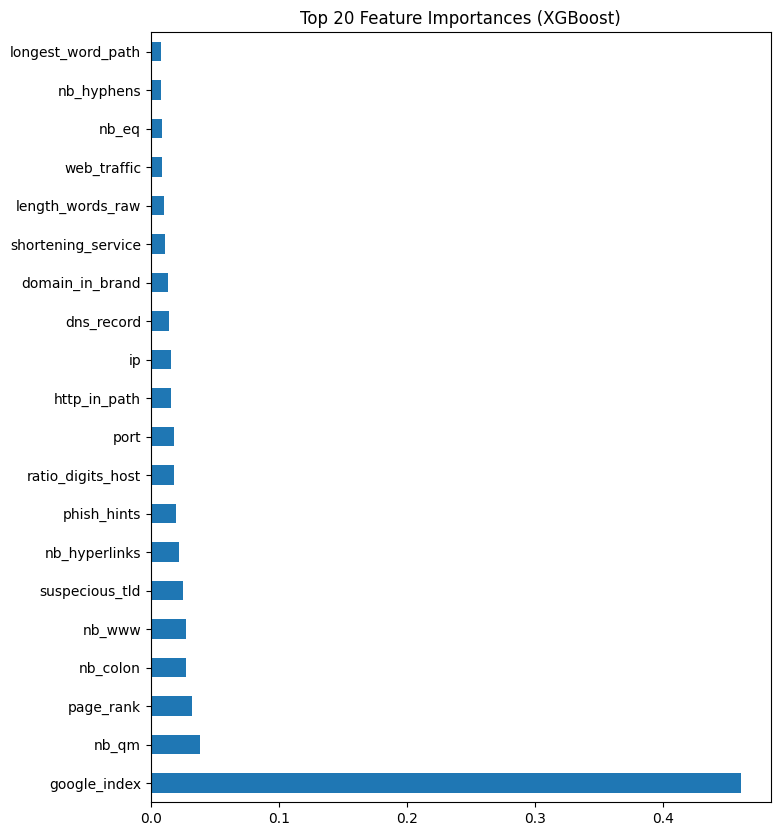

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(xgb.feature_importances_, index=X.columns)
importance.nlargest(20).plot(kind='barh', figsize=(8,10))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

Decision Tree Classifier

In [44]:
print("=" * 60)
print("TRAINING DECISION TREE CLASSIFIER")
print("=" * 60)

# Train Decision Tree with reasonable defaults
dt_model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    criterion='gini',
    random_state=42
)
dt_model.fit(X_train, y_train)

TRAINING DECISION TREE CLASSIFIER


,criterion,'gini'
,splitter,'best'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [45]:
print("=" * 60)
print("EVALUATING DECISION TREE")
print("=" * 60)

# Predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print(f"Accuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1-Score:  {f1_dt:.4f}")
print(f"ROC-AUC:   {roc_auc_dt:.4f}")

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(f"\nConfusion Matrix:")
print(cm_dt)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Legitimate', 'Phishing']))

EVALUATING DECISION TREE
Accuracy:  0.9440
Precision: 0.9527
Recall:    0.9344
F1-Score:  0.9435
ROC-AUC:   0.9563

Confusion Matrix:
[[1090   53]
 [  75 1068]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.94      0.95      0.94      1143
    Phishing       0.95      0.93      0.94      1143

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



In [46]:
from sklearn.preprocessing import StandardScaler

print("=" * 60)
print("TRAINING LASSO (L1) LOGISTIC REGRESSION")
print("=" * 60)

# Scale features (required for regularization)
lasso_scaler = StandardScaler()
X_train_scaled_lasso = lasso_scaler.fit_transform(X_train)
X_test_scaled_lasso = lasso_scaler.transform(X_test)



TRAINING LASSO (L1) LOGISTIC REGRESSION


In [47]:
# Train Lasso model
lasso_model = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    random_state=42,
    max_iter=1000
)


In [48]:
lasso_model.fit(X_train_scaled_lasso, y_train)



,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [49]:
# Cross-validation score
cv_scores_lasso = cross_val_score(lasso_model, X_train_scaled_lasso, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores_lasso.mean():.4f} (+/- {cv_scores_lasso.std():.4f})")



Cross-validation accuracy: 0.9462 (+/- 0.0053)


In [50]:
# Show feature selection (Lasso can zero out coefficients)
non_zero_features = np.sum(lasso_model.coef_ != 0)
print(f"Number of non-zero features: {non_zero_features} out of {X_train.shape[1]}")

Number of non-zero features: 74 out of 89


In [51]:
print("=" * 60)
print("EVALUATING LASSO (L1) LOGISTIC REGRESSION")
print("=" * 60)

# Predictions
y_pred_lasso = lasso_model.predict(X_test_scaled_lasso)
y_pred_proba_lasso = lasso_model.predict_proba(X_test_scaled_lasso)[:, 1]



EVALUATING LASSO (L1) LOGISTIC REGRESSION


In [52]:
# Calculate metrics
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
precision_lasso = precision_score(y_test, y_pred_lasso)
recall_lasso = recall_score(y_test, y_pred_lasso)
f1_lasso = f1_score(y_test, y_pred_lasso)
roc_auc_lasso = roc_auc_score(y_test, y_pred_proba_lasso)

print(f"Accuracy:  {accuracy_lasso:.4f}")
print(f"Precision: {precision_lasso:.4f}")
print(f"Recall:    {recall_lasso:.4f}")
print(f"F1-Score:  {f1_lasso:.4f}")
print(f"ROC-AUC:   {roc_auc_lasso:.4f}")

# Confusion Matrix
cm_lasso = confusion_matrix(y_test, y_pred_lasso)
print(f"\nConfusion Matrix:")
print(cm_lasso)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lasso, target_names=['Legitimate', 'Phishing']))

Accuracy:  0.9361
Precision: 0.9331
Recall:    0.9396
F1-Score:  0.9364
ROC-AUC:   0.9822

Confusion Matrix:
[[1066   77]
 [  69 1074]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.94      0.93      0.94      1143
    Phishing       0.93      0.94      0.94      1143

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



In [53]:
print("=" * 60)
print("TRAINING RIDGE (L2) LOGISTIC REGRESSION")
print("=" * 60)

# Scale features
ridge_scaler = StandardScaler()
X_train_scaled_ridge = ridge_scaler.fit_transform(X_train)
X_test_scaled_ridge = ridge_scaler.transform(X_test)

# Train Ridge model
ridge_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    random_state=42,
    max_iter=1000
)
ridge_model.fit(X_train_scaled_ridge, y_train)

# Cross-validation score
cv_scores_ridge = cross_val_score(ridge_model, X_train_scaled_ridge, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores_ridge.mean():.4f} (+/- {cv_scores_ridge.std():.4f})")

TRAINING RIDGE (L2) LOGISTIC REGRESSION
Cross-validation accuracy: 0.9461 (+/- 0.0049)


In [54]:
print("=" * 60)
print("EVALUATING RIDGE (L2) LOGISTIC REGRESSION")
print("=" * 60)

# Predictions
y_pred_ridge = ridge_model.predict(X_test_scaled_ridge)
y_pred_proba_ridge = ridge_model.predict_proba(X_test_scaled_ridge)[:, 1]

# Calculate metrics
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
precision_ridge = precision_score(y_test, y_pred_ridge)
recall_ridge = recall_score(y_test, y_pred_ridge)
f1_ridge = f1_score(y_test, y_pred_ridge)
roc_auc_ridge = roc_auc_score(y_test, y_pred_proba_ridge)

print(f"Accuracy:  {accuracy_ridge:.4f}")
print(f"Precision: {precision_ridge:.4f}")
print(f"Recall:    {recall_ridge:.4f}")
print(f"F1-Score:  {f1_ridge:.4f}")
print(f"ROC-AUC:   {roc_auc_ridge:.4f}")

# Confusion Matrix
cm_ridge = confusion_matrix(y_test, y_pred_ridge)
print(f"\nConfusion Matrix:")
print(cm_ridge)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ridge, target_names=['Legitimate', 'Phishing']))

EVALUATING RIDGE (L2) LOGISTIC REGRESSION
Accuracy:  0.9357
Precision: 0.9323
Recall:    0.9396
F1-Score:  0.9359
ROC-AUC:   0.9822

Confusion Matrix:
[[1065   78]
 [  69 1074]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.94      0.93      0.94      1143
    Phishing       0.93      0.94      0.94      1143

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



In [55]:
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': 'Decision Tree',
        'Accuracy': accuracy_dt,
        'Precision': precision_dt,
        'Recall': recall_dt,
        'F1-Score': f1_dt,
        'ROC-AUC': roc_auc_dt
    },
    {
        'Model': 'Lasso (L1) Logistic Regression',
        'Accuracy': accuracy_lasso,
        'Precision': precision_lasso,
        'Recall': recall_lasso,
        'F1-Score': f1_lasso,
        'ROC-AUC': roc_auc_lasso
    },
    {
        'Model': 'Ridge (L2) Logistic Regression',
        'Accuracy': accuracy_ridge,
        'Precision': precision_ridge,
        'Recall': recall_ridge,
        'F1-Score': f1_ridge,
        'ROC-AUC': roc_auc_ridge
    }
])

print(comparison_df.to_string(index=False))

# Find best model for each metric
print("\n" + "=" * 60)
print("BEST MODELS BY METRIC")
print("=" * 60)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_score = comparison_df.loc[best_idx, metric]
    print(f"{metric:12s}: {best_model:35s} ({best_score:.4f})")

MODEL COMPARISON
                         Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
                 Decision Tree  0.944007   0.952721 0.934383  0.943463 0.956319
Lasso (L1) Logistic Regression  0.936133   0.933102 0.939633  0.936356 0.982207
Ridge (L2) Logistic Regression  0.935696   0.932292 0.939633  0.935948 0.982181

BEST MODELS BY METRIC
Accuracy    : Decision Tree                       (0.9440)
Precision   : Decision Tree                       (0.9527)
Recall      : Lasso (L1) Logistic Regression      (0.9396)
F1-Score    : Decision Tree                       (0.9435)
ROC-AUC     : Lasso (L1) Logistic Regression      (0.9822)


In [56]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import numpy as np

# Drop 'url' column if it exists in X
if 'url' in X.columns:
    X_clean = X.drop(columns=['url'])
else:
    X_clean = X.copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y
)

# Define models with preprocessing pipeline
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocess),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocess),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocess),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
}

# Perform cross-validation
print("Cross-Validation Results (5-Fold):")
print("=" * 60)

cv_results = {}
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores
    
    print(f"\n{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Individual Folds: {cv_scores}")

# Train and evaluate best model on test set
print("\n" + "=" * 60)
print("Test Set Evaluation:")
print("=" * 60)

for name, model in models.items():
    # Fit on training data
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model.named_steps['classifier'], 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{name}:")
    print(f"  Test Accuracy: {accuracy:.4f}")
    
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"  ROC-AUC Score: {roc_auc:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

Cross-Validation Results (5-Fold):

Logistic Regression:
  CV Accuracy: 0.9278 (+/- 0.0104)
  Individual Folds: [0.92072171 0.92345544 0.93165664 0.92837616 0.93490153]

Random Forest:
  CV Accuracy: 0.9557 (+/- 0.0070)
  Individual Folds: [0.95297977 0.95844724 0.95188628 0.95407326 0.96115974]

Gradient Boosting:
  CV Accuracy: 0.9501 (+/- 0.0080)
  Individual Folds: [0.9486058  0.956807   0.94477857 0.9486058  0.95185996]

Test Set Evaluation:

Logistic Regression:
  Test Accuracy: 0.9291
  ROC-AUC Score: 0.9740

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.93      0.92      0.93      1143
    Phishing       0.92      0.93      0.93      1143

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286


Random Forest:
  Test Accuracy: 0.9576
  ROC-AUC Score: 0.9894

Classification Report:
              precision    recall  f1-sc

testing Model with new data set

In [57]:
import pandas as pd
import numpy as np
import re
import urllib.parse as urlparse
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib

In [59]:
# ------------------------------------------------------------------
# Adjust only if you moved the files
# ------------------------------------------------------------------
PROJECT_ROOT = r"C:\Users\levyc\OneDrive\PUGATORY\Nehemiah Mageto git projects\Detecting-Phishing-Websites-Using-URL-Based-HTML-Based-and-Domain-Based-Features"

TRAIN_CSV      = f"{PROJECT_ROOT}\dataset_phishing.csv"
NEW_CSV        = f"{PROJECT_ROOT}\phishtank-com-2025-12-02.csv"
MODEL_PKL      = f"{PROJECT_ROOT}\model.pkl"
TRANSFORMER_PKL = f"{PROJECT_ROOT}\preprocess_transformer.pkl"
PREDICTIONS_CSV = f"{PROJECT_ROOT}\predictions_phishtank_2025-12-02.csv"

In [60]:
def extract_url_parts(url):
    p = urlparse.urlparse(url)
    return p.hostname or "", p.path or "", p.query or ""

def is_ip(host):
    return int(bool(re.fullmatch(r'(?:\d{1,3}\.){3}\d{1,3}', host)))

def count_char(s, ch):
    return s.count(ch)

def ratio_digits(s):
    if not s:
        return 0.0
    digits = sum(c.isdigit() for c in s)
    return digits / len(s)

def word_stats(s):
    words = re.findall(r'\w+', s)
    if not words:
        return 0, 0, 0.0, 0
    lengths = [len(w) for w in words]
    return min(lengths), max(lengths), float(np.mean(lengths)), len(words)

Load training data & engineer its features

In [61]:
df_train = pd.read_csv(TRAIN_CSV)

# Ensure the raw URL column is called 'url' (rename if needed)
if 'url' not in df_train.columns:
    df_train = df_train.rename(columns={df_train.columns[0]: 'url'})

def engineer_features(df):
    # URL parts
    df['hostname'], df['path'], df['query'] = zip(*df['url'].apply(extract_url_parts))

    # ---------- Numerical ----------
    df['length_url']        = df['url'].apply(len)
    df['length_hostname']   = df['hostname'].apply(len)
    df['nb_hyphens']        = df['url'].apply(lambda x: count_char(x, '-'))
    df['nb_percent']        = df['url'].apply(lambda x: count_char(x, '%'))
    df['nb_slash']          = df['url'].apply(lambda x: count_char(x, '/'))
    df['ratio_digits_url']  = df['url'].apply(ratio_digits)
    df['ratio_digits_host'] = df['hostname'].apply(ratio_digits)

    short, long, avg_len, n_words = zip(*df['url'].apply(word_stats))
    df['shortest_words_raw'] = short
    df['longest_words_raw']  = long
    df['avg_words_raw']      = avg_len
    df['length_words_raw']   = n_words

    # ---------- Binary ----------
    df['ip']          = df['hostname'].apply(is_ip)
    df['nb_tilde']    = df['url'].apply(lambda x: int('~' in x))
    df['nb_star']     = df['url'].apply(lambda x: int('*' in x))
    df['nb_dslash']   = df['url'].apply(lambda x: int('//' in x))
    df['https_token'] = df['url'].apply(lambda x: int('https' in x.lower()))
    df['punycode']    = df['hostname'].apply(lambda x: int('xn--' in x.lower()))
    df['port']        = df['hostname'].apply(lambda x: int(':' in x and x.split(':')[-1].isdigit()))

    # ---------- Categorical counts ----------
    df['nb_dots']        = df['hostname'].apply(lambda x: count_char(x, '.'))
    df['nb_at']          = df['url'].apply(lambda x: count_char(x, '@'))
    df['nb_qm']          = df['url'].apply(lambda x: count_char(x, '?'))
    df['nb_and']         = df['url'].apply(lambda x: count_char(x, '&'))
    df['nb_or']          = df['url'].apply(lambda x: count_char(x, '|'))
    df['nb_eq']          = df['url'].apply(lambda x: count_char(x, '='))
    df['nb_underscore']  = df['url'].apply(lambda x: count_char(x, '_'))
    df['nb_colon']       = df['url'].apply(lambda x: count_char(x, ':'))
    df['nb_comma']       = df['url'].apply(lambda x: count_char(x, ','))
    df['nb_semicolumn']  = df['url'].apply(lambda x: count_char(x, ';'))

    return df

df_train = engineer_features(df_train)

 Define column groups (must match the groups used when the model was trained)
If you added extra engineered columns (e.g., html_danger_score, statistical_risk, domain_trust_score, …) add them to the appropriate list below.

In [62]:
numerical_cols = [
    'length_url','length_hostname','nb_hyphens','nb_percent','nb_slash',
    'ratio_digits_url','ratio_digits_host','length_words_raw','shortest_words_raw',
    'longest_words_raw','avg_words_raw','nb_hyperlinks','ratio_intHyperlinks',
    'ratio_extHyperlinks','nb_extCSS','ratio_extRedirection','ratio_extErrors',
    'links_in_tags','ratio_intMedia','ratio_extMedia','safe_anchor',
    'domain_registration_length','domain_age','web_traffic',
    # add any other numeric columns you created (e.g., `html_danger_score`, `statistical_risk`, …)
]

binary_cols = [
    'ip','nb_tilde','nb_star','nb_dslash','https_token','punycode','port',
    'tld_in_path','tld_in_subdomain','abnormal_subdomain','prefix_suffix',
    'random_domain','shortening_service','path_extension','nb_external_redirection',
    'domain_in_brand','brand_in_subdomain','brand_in_path','suspecious_tld',
    'login_form','external_favicon','iframe','popup_window','onmouseover',
    'right_clic','empty_title','domain_in_title','domain_with_copyright',
    'whois_registered_domain','dns_record','google_index'
]

categorical_cols = [
    'nb_dots','nb_at','nb_qm','nb_and','nb_or','nb_eq',
    'nb_underscore','nb_colon','nb_comma','nb_semicolumn'
]

Build & fit the preprocessing pipeline on the training data

In [64]:
numeric_tf = Pipeline([('scaler', StandardScaler())])
binary_tf  = 'passthrough'
categorical_tf = Pipeline([
    ('onehot', OneHotEncoder(drop='if_binary',
                             sparse_output=False,
                             handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numerical_cols),
        ('bin', binary_tf, binary_cols),
        ('cat', categorical_tf, categorical_cols)
    ],
    remainder='drop'
)

X_train = df_train[numerical_cols + binary_cols + categorical_cols]

# Fit **only** on the training data (this learns scalers & one‑hot encodings)
preprocess.fit(X_train)

# Save the fresh transformer for later use
joblib.dump(preprocess, TRANSFORMER_PKL)
print(f"✅ New transformer saved to {TRANSFORMER_PKL}")

✅ New transformer saved to C:\Users\levyc\OneDrive\PUGATORY\Nehemiah Mageto git projects\Detecting-Phishing-Websites-Using-URL-Based-HTML-Based-and-Domain-Based-Features\preprocess_transformer.pkl


Load the trained model (model.pkl)

In [66]:
model = joblib.load(MODEL_PKL)
print("✅ Model loaded.")

✅ Model loaded.


In [70]:
df_new = pd.read_csv('./phishtank-com-2025-12-02.csv')



In [71]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   web_scraper_order      154 non-null    object
 1   web_scraper_start_url  154 non-null    object
 2   category-link-0        154 non-null    object
 3   pagination-selector    132 non-null    object
 4   Phish URL              140 non-null    object
 5   Online?                122 non-null    object
 6   phone                  147 non-null    object
 7   Submitted              140 non-null    object
 8   Phish URL2             140 non-null    object
 9   Submitted2             140 non-null    object
 10  Valid?                 78 non-null     object
dtypes: object(11)
memory usage: 13.4+ KB


In [73]:
# PhishTank uses 'Phish URL' – rename to the name expected by the pipeline
df_new = df_new.rename(columns={'Phish URL': 'url'})



In [ ]:
df_new = engineer_features(df_new)   # reuse the same helper from step 4